In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import pytorch_lightning as pl
import torchdyn.models as models
import torch.utils.data as data

import numpy as np

D:\Programs\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Unsupported `ReduceOp` for distributed computing.
  warnings.warn(*args, **kwargs)


In [2]:
def v(x):  # q
    n = x.shape[0]  # size of batch trained on
    
    r_sq = (x**2).sum(axis=1)
    z = torch.exp(-0.5*r_sq) - torch.exp(-5*r_sq) + 0.5*torch.exp(
        -2*((x-torch.tensor([[1.0, 0.0] for _ in range(n)]))**2).sum(axis=1)  # see if there's a better way to do this transform
    )
    return torch.unsqueeze(z, dim=1)

In [3]:
grid = torch.tensor([[[[0.02*(x-100), 0.02*(y-100)]] for x in range(200)] for y in range(200)])
# grid is (200, 200, 1, 2): width, height, batch, coordinate

potential = torch.tensor([[v(x) for x in y] for y in grid])
grid.shape

torch.Size([200, 200, 1, 2])

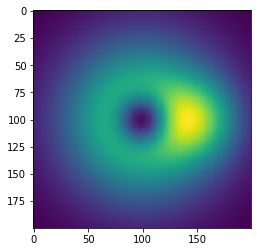

In [4]:
img_out = potential.detach().numpy()
plt.imshow(img_out)

In [5]:
class HNN(nn.Module):
    def __init__(self, dim=2):
        super().__init__()
        self.dim = dim
        self.v_learned = nn.Sequential(nn.Linear(2, 64), nn.Tanh(), nn.Linear(64, 1))  # V(q)
        
    def hamiltonian(self, x):  # x = (p, q), returns a scalar h (tensor w/ 1 element)
        p, q = torch.split(x, self.dim, dim=1)
        
        ke = torch.unsqueeze((p**2).sum(axis=1), dim=1)/2.0    # kinetic energy term
        v_given = v(q)           # given potential
        v_l = self.v_learned(q)  # learned potential
        
        h = ke + v_given + v_l
        return h
        
    def forward(self, x):
        with torch.set_grad_enabled(True):
            x = x.requires_grad_(True)
            
            h_grad = torch.autograd.grad(self.hamiltonian(x).sum(), x, create_graph=True)[0]
        return torch.cat([h_grad[:, self.dim:], h_grad[:, :self.dim]], 1).to(x)

In [6]:
class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        self.c = 0
        self.loss = torch.nn.MSELoss()
    
    def forward(self, x):
        return self.model.defunc(0,x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        y_hat = self.model.defunc(0,x)   
        loss = self.loss(y_hat, y)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

In [7]:
t = torch.linspace(0, 1, 3).reshape(-1,1)
data_in = torch.tensor(  # (p,q) training data: input
    [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.08, -0.1], [0.0, 0.0, 0.4, 1.6]]
)   
data_out = torch.tensor(  # (dp/dt, dq/dt) training data: output
    [[0.0, 0.7, 0.0, 0.0], [-0.9, 0.0, 0.0, 0.0], [-0.2, 0.0, 0.0, 0.0]]
)   

train = data.TensorDataset(data_in, data_out)
trainloader = data.DataLoader(train, batch_size=len(data_in), shuffle=False)

In [8]:
HamFunc = HNN()

In [9]:
model = models.NeuralDE(HamFunc)

learn = Learner(model)
trainer = pl.Trainer(min_epochs=300, max_epochs=300)
trainer.fit(learn)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
D:\Programs\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
D:\Programs\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type     | Params
-----------------------------------
0 | model | NeuralDE | 257   
1 | loss  | MSELoss  | 0     


Saving latest checkpoint..


1

In [10]:
learned_potential = torch.tensor([[HamFunc.v_learned(x) for x in y] for y in grid])
learned_potential.shape

torch.Size([200, 200])

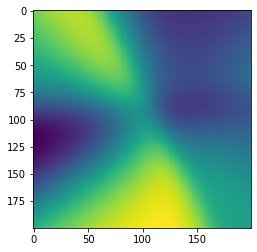

In [11]:
img_out = learned_potential.detach().numpy()
plt.imshow(img_out)